In [1]:
#necessary Libraries
import numpy as np
import pandas as pd
import time
import pprint

#Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
# magic word for producing visualizations in notebook
%matplotlib inline

#Preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA 
from scipy.sparse import lil_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#Models
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

#Scoring Metrics
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics
from sklearn.metrics import f1_score, fbeta_score
from sklearn.metrics import accuracy_score

In [2]:
# Load the dataset
file_path = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\ap_data_8r.csv'
ap_data = pd.read_csv(file_path)

In [3]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = ap_data.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 8
Number of rows: 102082


In [4]:
#check the statistics of the data per columns
ap_data.describe()

,channel,signal_strength,floorid,roomid
count,102082.000000,102082.000000,102082.000000,102082.000000
mean,2437.011461,-72.587322,212.528134,153.658422
std,18.420896,12.922178,104.984371,50.469398
min,2412.000000,-107.000000,1.000000,111.000000
25%,2417.000000,-83.000000,136.000000,111.000000
50%,2437.000000,-72.000000,214.000000,111.000000
75%,2457.000000,-63.000000,305.000000,213.000000
max,2462.000000,-5.000000,376.000000,214.000000


In [5]:
#Check the columns names
col_names = ap_data.columns.values
col_names

array(['mac_address', 'ssid', 'channel', 'source', 'signal_strength',
       'floorid', 'timestamp', 'roomid'], dtype=object)

In [6]:
#check for missing values
missing_values_count = ap_data.isnull().sum()
#uncomment this if you want to see the count of missing data per column
#missing_values_count

# how many total missing values do we have?
total_cells = np.product(ap_data.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
missing_percent = (total_missing/total_cells) * 100

print('Percent of missing data = {}%'.format(missing_percent))

Percent of missing data = 0.0%


In [11]:
# Add a new column 'source_without_C' by removing 'C' from 'source'
ap_data['ssid'] = ap_data['ssid'].str.replace('C', '')

# Convert the 'source_without_C' column to numeric
ap_data['ssid'] = pd.to_numeric(ap_data['ssid'], errors='coerce')

In [12]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = ap_data["ssid"].unique()
unique_channel = ap_data["channel"].unique()
unique_floorid = ap_data["floorid"].unique()
unique_roomid = ap_data["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel : {}'.format(unique_channel))
print('Unique Floor ID : {}'.format(unique_floorid))
print('Unique Room ID : {}'.format(unique_roomid))

unique_floorid_count = ap_data["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')

Unique SSID : [2 1]
Unique Channel : [2457 2462 2452 2447 2442 2417 2437 2412 2422 2427 2432]
Unique Floor ID : [ 78  69  60  51  42  33  24   7   8  15  16  25  23  32  41  50  59  68
  77   6   5   4   3   2   1  52  43  34  61  70  79  71  62  53  44  35
  26  17   9  10  11  12  13  14  18  20  21  22  27  28  29  30  31  36
  37  38  39  40  45  46  47  48  49  54  55  56  57  58  63  64  65  66
  67  72  73  74  75  76  19 189 188 187 186 185 184 183 182 181 171 172
 173 174 175 176 177 178 179 161 162 163 164 165 166 151 152 153 154 155
 156 141 142 143 144 145 146 131 132 133 134 135 136 121 122 123 124 125
 126 111 112 113 114 115 116 101 102 103 104 105 106 180 167 168 169 170
 157 158 159 160 147 148 149 150 137 138 139 140 127 128 129 130 117 118
 119 120 107 108 109 110 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240

KeyError: 'LONGITUDE'

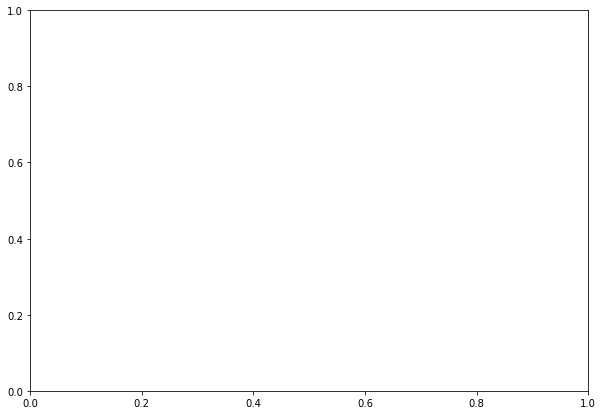

In [7]:
#map the data by user ID
#i.e. see how much of the information in each building was collected by how many users
ap_data.plot(kind="scatter", x="LONGITUDE", y="LATITUDE", alpha=0.4, figsize=(10,7),
    c="USERID", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.savefig('user_map_ap_data_8.png')

In [13]:
ap_data = ap_data.drop(['mac_address'], axis=1)

#Check the columns names
col_names = ap_data.columns.values
col_names

array(['ssid', 'channel', 'source', 'signal_strength', 'floorid',
       'timestamp', 'roomid'], dtype=object)

In [27]:
# Define the columns for duplication check
duplication_columns = ['ssid', 'channel', 'source', 'signal_strength', 'floorid']

# Count the number of occurrences for each combination of columns
ap_data['duplication_count'] = ap_data.groupby(duplication_columns)['ssid'].transform('count')

# Filter rows where duplication count is greater than or equal to 4
filtered_data = ap_data[ap_data['duplication_count'] >= 5]

# Save the result to a new CSV file or modify the original dataframe as needed
filtered_data.to_csv('filtered_data.csv', index=False)

print(filtered_data)

# Group by duplication columns and aggregate values using, for example, the mean
merged_data = filtered_data.groupby(duplication_columns, as_index=False).mean()

# Drop the 'duplication_count' column if you don't need it in the final result
merged_data = merged_data.drop(columns=['duplication_count'])

# Save the result to a new CSV file or modify the original dataframe as needed
merged_data.to_csv('merged_data.csv', index=False)

print(merged_data)

        ssid  channel source  signal_strength  floorid            timestamp  \
7          1     2462   cap1              -74       78  2023-12-13 16:21:03   
8          2     2462   cap2              -54       78  2023-12-13 16:21:03   
11         1     2462   cap1              -74       78  2023-12-13 16:21:03   
12         2     2462   cap2              -54       78  2023-12-13 16:21:03   
15         1     2462   cap1              -74       78  2023-12-13 16:21:03   
...      ...      ...    ...              ...      ...                  ...   
102076     2     2427   cap3              -66      376  2023-12-13 16:21:02   
102078     1     2432   cap2              -83      376  2023-12-13 16:21:02   
102079     2     2417   cap1              -77      376  2023-12-13 16:21:02   
102080     1     2432   cap1              -91      376  2023-12-13 16:21:02   
102081     1     2432   cap2              -83      376  2023-12-13 16:21:02   

        roomid  duplication_count  
7          214 

In [28]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = merged_data["ssid"].unique()
unique_channel = merged_data["channel"].unique()
unique_floorid = merged_data["floorid"].unique()
unique_roomid = merged_data["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel : {}'.format(unique_channel))
print('Unique Floor ID : {}'.format(unique_floorid))
print('Unique Room ID : {}'.format(unique_roomid))

unique_floorid_count = merged_data["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')


Unique SSID : [1 2]
Unique Channel : [2412 2417 2422 2427 2432 2437 2442 2447 2452 2457 2462]
Unique Floor ID : [219 231 233 190 192 234 191 218 228 230 222 225 235 217 333 221 321 306
 349 331 351 335 295 315 307 328 332 290 292 342 320 339 326 343 344 353
 341 334 232 214 226 229 227 302 215 220 216 304 367 297 301 313 325 305
 345 223 293 323 224 314 308 311 322 347 298 300 350 303 309 294 316 340
 317 318 319 338 327 329 291 336 346 337 299 296 324 312 363 119 365 352
 348 374 195 366 370 375 277 371 357 358 356 354 136 101 373 160 163 121
 166 175 161 162 131 187 127 140 165 330 170 196 310 194 355 376 364 359
 360 372 361 122 125 164 135 185 120 362 123 102 111 142 156 146 153 103
 145 117 159 113 168 157 138 169 148 118 130 151 152 141 149 158 154 183
 186 147 178 193 369 104 106 109 176 108 167 180 171 172 181 150 173 177
 112 124 174 115 182 107 128 137 129 110 139 132 143 133 114 126 144 188
 116 189 179 263 275 278 274 268 254 282 261 288 283 105 155 134 184 255
 262 289 267

In [29]:
# Count unique channels for each ssid, floorid, and source
merge_data = merged_data.groupby(['ssid', 'floorid', 'source'])['channel'].nunique().reset_index()

print(merge_data)

      ssid  floorid source  channel
0        1        1   cap1        2
1        1        1   cap2        3
2        1        2   cap1        1
3        1        2   cap2        2
4        1        3   cap1        3
...    ...      ...    ...      ...
1494     2      374   cap2        1
1495     2      374   cap3        3
1496     2      375   cap3        2
1497     2      376   cap1        2
1498     2      376   cap3        3

[1499 rows x 4 columns]


In [30]:
# Define a custom aggregation function to calculate the product
def calculate_product(x):
    return x.prod()

# Group by 'ssid' and 'floorid', then aggregate using the custom function
result = merge_data.groupby(['ssid', 'floorid']).agg({
    'channel': calculate_product
}).reset_index()

# Display the result
print(result)

# Continue from the previous code
total_sum_combination = result['channel'].sum()

# Display the total sum
print("Total Sum of 'channel' values:", total_sum_combination)


     ssid  floorid  channel
0       1        1        6
1       1        2        2
2       1        3        3
3       1        4        1
4       1        5        4
..    ...      ...      ...
703     2      372        6
704     2      373        8
705     2      374        3
706     2      375        2
707     2      376        6

[708 rows x 3 columns]
Total Sum of 'channel' values: 2556


In [31]:
# Count the number of unique sources per 'ssid' and 'floorid'
result_counts = merge_data.groupby(['ssid', 'floorid'])['source'].nunique().reset_index()

# Rename the column to indicate the count of sources
result_counts = result_counts.rename(columns={'source': 'source_count'})

# Display the result
print(result_counts)

# Save the result to a new CSV file or modify the original dataframe as needed
result_counts.to_csv('source_count.csv', index=False)

     ssid  floorid  source_count
0       1        1             2
1       1        2             2
2       1        3             2
3       1        4             2
4       1        5             2
..    ...      ...           ...
703     2      372             2
704     2      373             3
705     2      374             3
706     2      375             1
707     2      376             2

[708 rows x 3 columns]


In [32]:
# Calculate total RSSI for each unique channel within each ssid, floorid, and source
total_number_rssi = merged_data.groupby(['ssid', 'floorid', 'source', 'channel'])['signal_strength'].nunique().reset_index()

print(total_number_rssi)

      ssid  floorid source  channel  signal_strength
0        1        1   cap1     2457                1
1        1        1   cap1     2462                4
2        1        1   cap2     2452                2
3        1        1   cap2     2457                1
4        1        1   cap2     2462                2
...    ...      ...    ...      ...              ...
2776     2      376   cap1     2412                1
2777     2      376   cap1     2417                2
2778     2      376   cap3     2412                1
2779     2      376   cap3     2417                1
2780     2      376   cap3     2427                4

[2781 rows x 5 columns]


In [33]:
print(merged_data)

      ssid  channel source  signal_strength  floorid  roomid
0        1     2412   cap1              -94      219     111
1        1     2412   cap1              -93      231     111
2        1     2412   cap1              -93      233     111
3        1     2412   cap1              -92      190     111
4        1     2412   cap1              -92      192     111
...    ...      ...    ...              ...      ...     ...
5614     2     2462   cap3              -73      209     111
5615     2     2462   cap3              -73      210     111
5616     2     2462   cap3              -65      205     111
5617     2     2462   cap3              -64      205     111
5618     2     2462   cap3              -62      205     111

[5619 rows x 6 columns]


In [34]:
import pandas as pd
from itertools import product

start_time = time.time()


# Step 1: Identify missing sources and add rows with 0 channel and 100 signal_strength


# List of sources to check for each ssid and floorid combination
sources_to_check = ['cap1', 'cap2', 'cap3']

# Create a MultiIndex from ssid and floorid
index_cols = ['ssid', 'floorid']
multi_index = pd.MultiIndex.from_frame(merged_data[index_cols])

# Iterate over unique ssid and floorid combinations
for ssid, floorid in multi_index.unique():
    # Filter data for the current ssid and floorid
    subset = merged_data[(merged_data['ssid'] == ssid) & (merged_data['floorid'] == floorid)]
    
    # Get the sources present in the subset
    present_sources = subset['source'].unique()
    
    # Find the missing sources
    missing_sources = set(sources_to_check) - set(present_sources)
    
    # Add rows for missing sources
    for missing_source in missing_sources:
        merged_data = merged_data.append({
            'ssid': ssid,
            'channel': 0,
            'source': missing_source,
            'signal_strength': 100,
            'floorid': floorid,
            'roomid': subset['roomid'].iloc[0]  # Assuming roomid is the same for all rows in the subset
        }, ignore_index=True)

# Sort the DataFrame by ssid and floorid
merged_data = merged_data.sort_values(by=['ssid', 'floorid']).reset_index(drop=True)

# Remove rows where ssid is 0
merged_data = merged_data[merged_data['ssid'] != 0]

# Display the result
print(merged_data)

merged_data.to_csv('merged_data_with_0.csv', index=False)

print(merged_data)

# Step 2: Extract unique combinations of 'ssid', 'floorid', and 'roomid'
combinations = merged_data[['ssid', 'floorid', 'roomid']].drop_duplicates()

# Step 3: Calculate unique channels for each source
channel_counts = {}
for index, row in combinations.iterrows():
    ssid, floorid, roomid = row['ssid'], row['floorid'], row['roomid']
    channels = merged_data[(merged_data['ssid'] == ssid) & 
                           (merged_data['floorid'] == floorid) & 
                           (merged_data['roomid'] == roomid)].groupby('source')['channel'].unique()
    channel_counts[(ssid, floorid, roomid)] = channels

print(channel_counts)

# Step 4 and 5: Generate combinations and create DataFrame
combinations_list = []
for (ssid, floorid, roomid), channels in channel_counts.items():
    for source, channel_list in channels.items():
        for channel in channel_list:
            signal_strengths = merged_data[
                (merged_data['ssid'] == ssid) &
                (merged_data['floorid'] == floorid) &
                (merged_data['roomid'] == roomid) &
                (merged_data['source'] == source) &
                (merged_data['channel'] == channel)
            ]['signal_strength'].tolist()

            total_signal_strengths = len(signal_strengths)

            print(f'SSID: {ssid}, FloorID: {floorid}, RoomID: {roomid}, Total Number of Signal Strength for {source} channel {channel}: {total_signal_strengths}')

            combination = [ssid, floorid, roomid, source, f'channel_{channel}_signal_strength_{source}', signal_strengths]
            combinations_list.append(combination)

            
print(combinations_list)

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

      ssid  channel source  signal_strength  floorid  roomid
0        1     2452   cap2              -65        1     214
1        1     2452   cap2              -63        1     214
2        1     2457   cap1              -80        1     214
3        1     2457   cap2              -63        1     214
4        1     2462   cap1              -82        1     214
...    ...      ...    ...              ...      ...     ...
6239     2     2427   cap3              -81      376     111
6240     2     2427   cap3              -66      376     111
6241     2     2427   cap3              -61      376     111
6242     2     2427   cap3              -58      376     111
6243     2        0   cap2              100      376     111

[6244 rows x 6 columns]
      ssid  channel source  signal_strength  floorid  roomid
0        1     2452   cap2              -65        1     214
1        1     2452   cap2              -63        1     214
2        1     2457   cap1              -80        1     214

SSID: 1, FloorID: 19, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 4
SSID: 1, FloorID: 19, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 20, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 1, FloorID: 20, RoomID: 214, Total Number of Signal Strength for cap2 channel 2452: 2
SSID: 1, FloorID: 20, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 1, FloorID: 20, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 2
SSID: 1, FloorID: 20, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 21, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 1, FloorID: 21, RoomID: 214, Total Number of Signal Strength for cap2 channel 2452: 1
SSID: 1, FloorID: 21, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 4
SSID: 1, FloorID: 21, RoomID: 214, Total Number of Signal Strength for cap3 channel 0:

SSID: 1, FloorID: 53, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 1
SSID: 1, FloorID: 53, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 54, RoomID: 214, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 1, FloorID: 54, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 1
SSID: 1, FloorID: 54, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 2
SSID: 1, FloorID: 54, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 1
SSID: 1, FloorID: 54, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 55, RoomID: 214, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 1, FloorID: 55, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 1
SSID: 1, FloorID: 55, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 2
SSID: 1, FloorID: 55, RoomID: 214, Total Number of Signal Strength for cap3 channel 0:

SSID: 1, FloorID: 105, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 2
SSID: 1, FloorID: 105, RoomID: 213, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 106, RoomID: 213, Total Number of Signal Strength for cap1 channel 2437: 1
SSID: 1, FloorID: 106, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 1
SSID: 1, FloorID: 106, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 106, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 2
SSID: 1, FloorID: 106, RoomID: 213, Total Number of Signal Strength for cap2 channel 2447: 1
SSID: 1, FloorID: 106, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 4
SSID: 1, FloorID: 107, RoomID: 213, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 107, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 107, RoomID: 213, Total Number of Signal Strength for cap2

SSID: 1, FloorID: 133, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 1, FloorID: 134, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 1
SSID: 1, FloorID: 134, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 1
SSID: 1, FloorID: 134, RoomID: 213, Total Number of Signal Strength for cap2 channel 2447: 1
SSID: 1, FloorID: 134, RoomID: 213, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 1, FloorID: 135, RoomID: 213, Total Number of Signal Strength for cap1 channel 2432: 1
SSID: 1, FloorID: 135, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 2
SSID: 1, FloorID: 135, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 1
SSID: 1, FloorID: 135, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 135, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 2
SSID: 1, FloorID: 135, RoomID: 213, Total Number of Signal Strength for c

SSID: 1, FloorID: 159, RoomID: 213, Total Number of Signal Strength for cap2 channel 2432: 2
SSID: 1, FloorID: 159, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 1
SSID: 1, FloorID: 159, RoomID: 213, Total Number of Signal Strength for cap2 channel 2447: 2
SSID: 1, FloorID: 159, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 1
SSID: 1, FloorID: 159, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 2
SSID: 1, FloorID: 160, RoomID: 213, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 160, RoomID: 213, Total Number of Signal Strength for cap2 channel 2427: 1
SSID: 1, FloorID: 160, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 1
SSID: 1, FloorID: 160, RoomID: 213, Total Number of Signal Strength for cap2 channel 2447: 1
SSID: 1, FloorID: 160, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 1
SSID: 1, FloorID: 160, RoomID: 213, Total Number of Signal Strength for c

SSID: 1, FloorID: 181, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 1
SSID: 1, FloorID: 182, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 1
SSID: 1, FloorID: 182, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 1
SSID: 1, FloorID: 182, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 182, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 1
SSID: 1, FloorID: 182, RoomID: 213, Total Number of Signal Strength for cap2 channel 2447: 1
SSID: 1, FloorID: 182, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 1, FloorID: 183, RoomID: 213, Total Number of Signal Strength for cap1 channel 2437: 1
SSID: 1, FloorID: 183, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 2
SSID: 1, FloorID: 183, RoomID: 213, Total Number of Signal Strength for cap2 channel 2437: 1
SSID: 1, FloorID: 183, RoomID: 213, Total Number of Signal Strength fo

SSID: 1, FloorID: 207, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 1
SSID: 1, FloorID: 207, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 3
SSID: 1, FloorID: 207, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 5
SSID: 1, FloorID: 208, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 208, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 208, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 1
SSID: 1, FloorID: 208, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 2
SSID: 1, FloorID: 208, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 5
SSID: 1, FloorID: 209, RoomID: 111, Total Number of Signal Strength for cap1 channel 2452: 3
SSID: 1, FloorID: 209, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 209, RoomID: 111, Total Number of Signal Strength for cap3 ch

SSID: 1, FloorID: 235, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 1, FloorID: 235, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 1, FloorID: 236, RoomID: 111, Total Number of Signal Strength for cap1 channel 2462: 1
SSID: 1, FloorID: 236, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 236, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 2
SSID: 1, FloorID: 236, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 4
SSID: 1, FloorID: 237, RoomID: 111, Total Number of Signal Strength for cap1 channel 2462: 1
SSID: 1, FloorID: 237, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 237, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 1
SSID: 1, FloorID: 237, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 7
SSID: 1, FloorID: 238, RoomID: 111, Total Number of Signal Strength for cap1

SSID: 1, FloorID: 264, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 264, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 264, RoomID: 111, Total Number of Signal Strength for cap3 channel 2442: 2
SSID: 1, FloorID: 264, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 3
SSID: 1, FloorID: 265, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 265, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 265, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 1, FloorID: 265, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 1
SSID: 1, FloorID: 266, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 266, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 266, RoomID: 111, Total Number of Signal Strength for cap3 channel 244

SSID: 1, FloorID: 293, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 293, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 4
SSID: 1, FloorID: 293, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 2
SSID: 1, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 3
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap3 ch

SSID: 1, FloorID: 322, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 322, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 1, FloorID: 322, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 1, FloorID: 322, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 5
SSID: 1, FloorID: 322, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 1, FloorID: 323, RoomID: 111, Total Number of Signal Strength for cap1 channel 2422: 1
SSID: 1, FloorID: 323, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 323, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 1, FloorID: 323, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 1, FloorID: 323, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 1, FloorID: 323, RoomID: 111, Total Number of Signal Strength for cap3

SSID: 1, FloorID: 351, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 1
SSID: 1, FloorID: 351, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 5
SSID: 1, FloorID: 352, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 1, FloorID: 352, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 1, FloorID: 352, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 2
SSID: 1, FloorID: 352, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 2
SSID: 1, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 1, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap1 channel 2427: 2
SSID: 1, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 2
SSID: 1, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 3
SSID: 1, FloorID: 353, RoomID: 111, Total Number of Signal Strength for cap3

SSID: 2, FloorID: 4, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 4, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 4, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 4, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 5, RoomID: 214, Total Number of Signal Strength for cap1 channel 2452: 1
SSID: 2, FloorID: 5, RoomID: 214, Total Number of Signal Strength for cap1 channel 2457: 2
SSID: 2, FloorID: 5, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 1
SSID: 2, FloorID: 5, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 5, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 5, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 6, RoomID: 214, Total Number of Signal Strength for cap1 channel 2457: 1
SSID:

SSID: 2, FloorID: 37, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 4
SSID: 2, FloorID: 37, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 37, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 37, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 38, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 38, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 38, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 39, RoomID: 214, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 2, FloorID: 39, RoomID: 214, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 39, RoomID: 214, Total Number of Signal Strength for cap2 channel 2462: 1
SSID: 2, FloorID: 39, RoomID: 214, Total Number of Signal Strength for cap3 channel 0:

SSID: 2, FloorID: 73, RoomID: 214, Total Number of Signal Strength for cap1 channel 2412: 2
SSID: 2, FloorID: 73, RoomID: 214, Total Number of Signal Strength for cap1 channel 2417: 1
SSID: 2, FloorID: 73, RoomID: 214, Total Number of Signal Strength for cap1 channel 2422: 1
SSID: 2, FloorID: 73, RoomID: 214, Total Number of Signal Strength for cap2 channel 2417: 2
SSID: 2, FloorID: 73, RoomID: 214, Total Number of Signal Strength for cap2 channel 2422: 1
SSID: 2, FloorID: 73, RoomID: 214, Total Number of Signal Strength for cap3 channel 0: 1
SSID: 2, FloorID: 74, RoomID: 214, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 74, RoomID: 214, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 2, FloorID: 74, RoomID: 214, Total Number of Signal Strength for cap1 channel 2422: 1
SSID: 2, FloorID: 74, RoomID: 214, Total Number of Signal Strength for cap2 channel 2417: 2
SSID: 2, FloorID: 74, RoomID: 214, Total Number of Signal Strength for cap3 channel

SSID: 2, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 2, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 131, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 2
SSID: 2, FloorID: 132, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 132, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 132, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 2
SSID: 2, FloorID: 133, RoomID: 213, Total Number of Signal Strength for cap1 channel 2457: 2
SSID: 2, FloorID: 133, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 2, FloorID: 133, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 133, RoomID: 213, Total Number of Signal Strength fo

SSID: 2, FloorID: 155, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 1
SSID: 2, FloorID: 156, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 2
SSID: 2, FloorID: 156, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 4
SSID: 2, FloorID: 156, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 2
SSID: 2, FloorID: 157, RoomID: 213, Total Number of Signal Strength for cap1 channel 2462: 3
SSID: 2, FloorID: 157, RoomID: 213, Total Number of Signal Strength for cap2 channel 2457: 1
SSID: 2, FloorID: 157, RoomID: 213, Total Number of Signal Strength for cap2 channel 2462: 3
SSID: 2, FloorID: 157, RoomID: 213, Total Number of Signal Strength for cap3 channel 2457: 1
SSID: 2, FloorID: 157, RoomID: 213, Total Number of Signal Strength for cap3 channel 2462: 3
SSID: 2, FloorID: 158, RoomID: 213, Total Number of Signal Strength for cap1 channel 2457: 1
SSID: 2, FloorID: 158, RoomID: 213, Total Number of Signal Strength fo

SSID: 2, FloorID: 177, RoomID: 213, Total Number of Signal Strength for cap2 channel 2447: 1
SSID: 2, FloorID: 177, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 2
SSID: 2, FloorID: 177, RoomID: 213, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 2, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 1
SSID: 2, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap1 channel 2447: 2
SSID: 2, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap2 channel 2442: 2
SSID: 2, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap3 channel 2432: 1
SSID: 2, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap3 channel 2437: 3
SSID: 2, FloorID: 178, RoomID: 213, Total Number of Signal Strength for cap3 channel 2442: 2
SSID: 2, FloorID: 179, RoomID: 213, Total Number of Signal Strength for cap1 channel 2442: 1
SSID: 2, FloorID: 179, RoomID: 213, Total Number of Signal Strength fo

SSID: 2, FloorID: 204, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 204, RoomID: 111, Total Number of Signal Strength for cap3 channel 2447: 1
SSID: 2, FloorID: 204, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 1
SSID: 2, FloorID: 204, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 3
SSID: 2, FloorID: 205, RoomID: 111, Total Number of Signal Strength for cap1 channel 2452: 3
SSID: 2, FloorID: 205, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 205, RoomID: 111, Total Number of Signal Strength for cap3 channel 2452: 1
SSID: 2, FloorID: 205, RoomID: 111, Total Number of Signal Strength for cap3 channel 2457: 4
SSID: 2, FloorID: 205, RoomID: 111, Total Number of Signal Strength for cap3 channel 2462: 3
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap1 channel 2452: 3
SSID: 2, FloorID: 206, RoomID: 111, Total Number of Signal Strength for cap2

SSID: 2, FloorID: 231, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 3
SSID: 2, FloorID: 231, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 231, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 231, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 231, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 2, FloorID: 232, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 232, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 232, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 232, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 3
SSID: 2, FloorID: 232, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 3
SSID: 2, FloorID: 233, RoomID: 111, Total Number of Signal Strength for cap1 ch

SSID: 2, FloorID: 253, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 253, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 253, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 253, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 2, FloorID: 253, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 2, FloorID: 254, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 254, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 1
SSID: 2, FloorID: 254, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 254, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 254, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 4
SSID: 2, FloorID: 254, RoomID: 111, Total Number of Signal Strength for cap3

SSID: 2, FloorID: 271, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 4
SSID: 2, FloorID: 271, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 2, FloorID: 271, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 2
SSID: 2, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 4
SSID: 2, FloorID: 272, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 2, FloorID: 274, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 274, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 1
SSID: 2, FloorID: 274, RoomID: 111, Total Number of Signal Strength for c

SSID: 2, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 2, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 2
SSID: 2, FloorID: 294, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 2
SSID: 2, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 2
SSID: 2, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 2, FloorID: 295, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 4
SSID: 2, FloorID: 296, RoomID: 111, Total Number of Signal Strength for c

SSID: 2, FloorID: 319, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 319, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 319, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 5
SSID: 2, FloorID: 320, RoomID: 111, Total Number of Signal Strength for cap1 channel 2412: 1
SSID: 2, FloorID: 320, RoomID: 111, Total Number of Signal Strength for cap1 channel 2422: 1
SSID: 2, FloorID: 320, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 2
SSID: 2, FloorID: 320, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 320, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 2, FloorID: 320, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 3
SSID: 2, FloorID: 321, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 321, RoomID: 111, Total Number of Signal Strength for cap2

SSID: 2, FloorID: 345, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 1
SSID: 2, FloorID: 345, RoomID: 111, Total Number of Signal Strength for cap3 channel 2422: 1
SSID: 2, FloorID: 345, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 4
SSID: 2, FloorID: 346, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 2
SSID: 2, FloorID: 346, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 346, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 2
SSID: 2, FloorID: 346, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 7
SSID: 2, FloorID: 347, RoomID: 111, Total Number of Signal Strength for cap1 channel 0: 1
SSID: 2, FloorID: 347, RoomID: 111, Total Number of Signal Strength for cap2 channel 0: 1
SSID: 2, FloorID: 347, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 347, RoomID: 111, Total Number of Signal Strength for cap3 ch

SSID: 2, FloorID: 370, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 1
SSID: 2, FloorID: 370, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 1
SSID: 2, FloorID: 370, RoomID: 111, Total Number of Signal Strength for cap2 channel 2417: 1
SSID: 2, FloorID: 370, RoomID: 111, Total Number of Signal Strength for cap3 channel 2412: 1
SSID: 2, FloorID: 370, RoomID: 111, Total Number of Signal Strength for cap3 channel 2417: 2
SSID: 2, FloorID: 370, RoomID: 111, Total Number of Signal Strength for cap3 channel 2427: 1
SSID: 2, FloorID: 370, RoomID: 111, Total Number of Signal Strength for cap3 channel 2437: 2
SSID: 2, FloorID: 371, RoomID: 111, Total Number of Signal Strength for cap1 channel 2417: 3
SSID: 2, FloorID: 371, RoomID: 111, Total Number of Signal Strength for cap1 channel 2422: 2
SSID: 2, FloorID: 371, RoomID: 111, Total Number of Signal Strength for cap2 channel 2412: 2
SSID: 2, FloorID: 371, RoomID: 111, Total Number of Signal Strength fo

In [35]:
# Assuming the 'roomid' column is present in the 'merged_data' DataFrame

# Step 6: Combine the RSSI from each row
combined_rssi = pd.DataFrame(columns=['ssid', 'floorid', 'roomid', 'channel_cap1', 'channel_cap2', 'channel_cap3', 'signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3'])

for (ssid, floorid, roomid), channels in channel_counts.items():
    product_list = product(*(channels[source] for source in channels.keys()))

    for combination in product_list:
        row = {'ssid': ssid, 'floorid': floorid, 'roomid': merged_data[(merged_data['ssid'] == ssid) & (merged_data['floorid'] == floorid)]['roomid'].values[0]}
        for i, (source, channel) in enumerate(zip(channels.keys(), combination), start=1):
            row[f'channel_{source}'] = channel
            signal_strengths = merged_data[
                (merged_data['ssid'] == ssid) &
                (merged_data['floorid'] == floorid) &
                (merged_data['source'] == source) &
                (merged_data['channel'] == channel)
            ]['signal_strength'].tolist()

            row[f'signal_strength_cap{i}'] = signal_strengths if signal_strengths else None

        combined_rssi = combined_rssi.append(row, ignore_index=True)

print(combined_rssi)
combined_rssi.to_csv('combined_rssi_knn.csv', index=False)

     ssid floorid roomid channel_cap1 channel_cap2 channel_cap3  \
0       1       1    214         2457         2452            0   
1       1       1    214         2457         2457            0   
2       1       1    214         2457         2462            0   
3       1       1    214         2462         2452            0   
4       1       1    214         2462         2457            0   
...   ...     ...    ...          ...          ...          ...   
2551    2     376    111         2412            0         2417   
2552    2     376    111         2412            0         2427   
2553    2     376    111         2417            0         2412   
2554    2     376    111         2417            0         2417   
2555    2     376    111         2417            0         2427   

      signal_strength_cap1 signal_strength_cap2  signal_strength_cap3  
0                    [-80]           [-65, -63]                 [100]  
1                    [-80]                [-63]    

In [36]:
# Step 7: Combine the RSSI from each row
combined_rssi_final = pd.DataFrame(columns=combined_rssi.columns)  # Initialize an empty DataFrame

for index, row in combined_rssi.head(total_sum_combination).iterrows():  # Iterate only over the first 9 rows
    ssid, floorid, roomid, channel_cap1, channel_cap2, channel_cap3 = row['ssid'], row['floorid'], row['roomid'], row['channel_cap1'], row['channel_cap2'], row['channel_cap3']
    
    # Create all possible combinations of signal strengths
    signal_strengths = [row['signal_strength_cap1'], row['signal_strength_cap2'], row['signal_strength_cap3']]
    
    # Handle the case where signal strength is an integer (100)
    signal_combinations = [signal if isinstance(signal, list) else [signal] for signal in signal_strengths]
    
    for signal_combination in product(*signal_combinations):
        combined_rssi_final = combined_rssi_final.append({
            'ssid': ssid,
            'floorid': floorid,
            'roomid': roomid,
            'channel_cap1': channel_cap1,
            'channel_cap2': channel_cap2,
            'channel_cap3': channel_cap3,
            'signal_strength_cap1': signal_combination[0],
            'signal_strength_cap2': signal_combination[1],
            'signal_strength_cap3': signal_combination[2]
        }, ignore_index=True)

# Display the result
print(combined_rssi_final)

combined_rssi_final.to_csv('combined_rssi_final_testing.csv', index=False)


      ssid floorid roomid channel_cap1 channel_cap2 channel_cap3  \
0        1       1    214         2457         2452            0   
1        1       1    214         2457         2452            0   
2        1       1    214         2457         2457            0   
3        1       1    214         2457         2462            0   
4        1       1    214         2457         2462            0   
...    ...     ...    ...          ...          ...          ...   
12458    2     376    111         2417            0         2427   
12459    2     376    111         2417            0         2427   
12460    2     376    111         2417            0         2427   
12461    2     376    111         2417            0         2427   
12462    2     376    111         2417            0         2427   

      signal_strength_cap1 signal_strength_cap2 signal_strength_cap3  
0                      -80                  -65                  100  
1                      -80               

In [37]:
# Check the structure of the data after it's loaded 
#(print the number of rows and columns).
num_rows, num_cols  = combined_rssi_final.shape
print('Number of columns: {}'.format(num_cols))
print('Number of rows: {}'.format(num_rows))

Number of columns: 9
Number of rows: 12463


In [38]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = combined_rssi_final["ssid"].unique()
unique_channel_cap1 = combined_rssi_final["channel_cap1"].unique()
unique_channel_cap2 = combined_rssi_final["channel_cap2"].unique()
unique_channel_cap3 = combined_rssi_final["channel_cap3"].unique()
unique_floorid = combined_rssi_final["floorid"].unique()
unique_roomid = combined_rssi_final["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel cap1 : {}'.format(unique_channel_cap1))
print('Unique Channel cap2: {}'.format(unique_channel_cap2))
print('Unique Channel cap3: {}'.format(unique_channel_cap3))

# Assuming unique_floorid is a NumPy array or a pandas Series
unique_floorid_sorted = np.sort(unique_floorid)

print('Unique Floor ID (Sorted):', unique_floorid_sorted)

print('Unique Room ID : {}'.format(unique_roomid))

unique_channels_combined = np.union1d(np.union1d(unique_channel_cap1, unique_channel_cap2), unique_channel_cap3)

print('Unique Channel combined:', unique_channels_combined)

unique_floorid_count = combined_rssi_final["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')

Unique SSID : [1 2]
Unique Channel cap1 : [2457 2462 2452 0 2427 2432 2442 2447 2437 2422 2412 2417]
Unique Channel cap2: [2452 2457 2462 2447 2432 2437 2442 2427 2412 0 2417 2422]
Unique Channel cap3: [0 2462 2437 2442 2432 2447 2427 2412 2417 2422 2457 2452]
Unique Floor ID (Sorted): [1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115
 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169
 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 207 208 209 210 211 212 213 214 215 216 217 218 219

In [261]:
#Preprocess the Training Data Set //////////////////////////////////////////////////////////////////////////////////////////////

In [52]:
# Load the dataset
file_path = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\combined_rssi_final.csv'
trainingData = pd.read_csv(file_path)

print(trainingData)

       ssid  floorid  roomid  channel_cap1  channel_cap2  channel_cap3  \
0         1        1     216          2457          2452             0   
1         1        1     216          2457          2452             0   
2         1        1     216          2457          2457             0   
3         1        1     216          2457          2462             0   
4         1        1     216          2457          2462             0   
...     ...      ...     ...           ...           ...           ...   
15915     2      376     111          2417             0          2427   
15916     2      376     111          2417             0          2427   
15917     2      376     111          2417             0          2427   
15918     2      376     111          2417             0          2427   
15919     2      376     111          2417             0          2427   

       signal_strength_cap1  signal_strength_cap2  signal_strength_cap3  
0                       -80          

In [53]:
def clean_data(df):
    """
    Perform feature trimming, and engineering for trainingData
    Will also be applied to validationData
    
    INPUT: trainingData DataFrame
    OUTPUT: Trimmed and cleaned trainingData DataFrame
    """
    
    # Reverse the representation for the values. 100=0 and teh values range from 0-105 (weakest to strongest)
    #"The intensity values are represented as negative integer values ranging -104dBm (extremely poor signal) to 0dbM.
    #The positive value 100 is used to denote when a WAP was not detected."
    
    '''
    df.iloc[:, 5:8] = np.where(df.iloc[:, 5:8] <= 0, 
                df.iloc[:, 5:8] + 105, 
                df.iloc[:, 5:8] - 100)
    '''
    
    '''
    df.iloc[:, 6:9] = np.where(df.iloc[:, 6:9] > 2000, 
                df.iloc[:, 6:9] - 2300, 
                df.iloc[:, 6:9] - 0)
    '''
    
    '''  
    # Remove rows if there are two zeroes in a row in the cap_channel
    df = df[
    ~((df['channel_cap1'] == 0) & (df['channel_cap2'] == 0)) &
    ~((df['channel_cap1'] == 0) & (df['channel_cap3'] == 0)) &
    ~((df['channel_cap2'] == 0) & (df['channel_cap3'] == 0))
    ]

     
    # Remove rows if there are one zeroes in a row in the cap_channel
    df = df[
    ~((df['channel_cap1'] == 0)) &
    ~((df['channel_cap2'] == 0)) &
    ~((df['channel_cap3'] == 0)) 
    ]
    ''' 

    # Return the cleaned dataframe.
    return df 

In [54]:
#Apply Cleaning

trainingData  = clean_data(trainingData)


trainingData.to_csv('trainingData-ap_data_ap_data_8.csv', index=False)

print(trainingData)

       ssid  floorid  roomid  channel_cap1  channel_cap2  channel_cap3  \
0         1        1     216          2457          2452             0   
1         1        1     216          2457          2452             0   
2         1        1     216          2457          2457             0   
3         1        1     216          2457          2462             0   
4         1        1     216          2457          2462             0   
...     ...      ...     ...           ...           ...           ...   
15915     2      376     111          2417             0          2427   
15916     2      376     111          2417             0          2427   
15917     2      376     111          2417             0          2427   
15918     2      376     111          2417             0          2427   
15919     2      376     111          2417             0          2427   

       signal_strength_cap1  signal_strength_cap2  signal_strength_cap3  
0                       -80          

In [55]:
#Assess unique values per columns
#unique_mac_address = ap_data["mac_address"].unique()
unique_ssid = trainingData["ssid"].unique()
unique_channel_cap1 = trainingData["channel_cap1"].unique()
unique_channel_cap2 = trainingData["channel_cap2"].unique()
unique_channel_cap3 = trainingData["channel_cap3"].unique()
unique_floorid = trainingData["floorid"].unique()
unique_roomid = trainingData["roomid"].unique()

#print('Unique Mac Address : {}'.format(unique_mac_address))
print('Unique SSID : {}'.format(unique_ssid))
print('Unique Channel cap1 : {}'.format(unique_channel_cap1))
print('Unique Channel cap2: {}'.format(unique_channel_cap2))
print('Unique Channel cap3: {}'.format(unique_channel_cap3))

# Assuming unique_floorid is a NumPy array or a pandas Series
unique_floorid_sorted = np.sort(unique_floorid)

print('Unique Floor ID (Sorted):', unique_floorid_sorted)

print('Unique Room ID : {}'.format(unique_roomid))

unique_channels_combined = np.union1d(np.union1d(unique_channel_cap1, unique_channel_cap2), unique_channel_cap3)

print('Unique Channel combined:', unique_channels_combined)

unique_floorid_count = trainingData["floorid"].nunique()
print(f'Number of Unique Floor IDs: {unique_floorid_count}')

Unique SSID : [1 2]
Unique Channel cap1 : [2457 2462 2452    0 2412 2432 2427 2417 2442 2447 2422 2437]
Unique Channel cap2: [2452 2457 2462 2447 2412    0 2442 2437 2432 2427 2417 2422]
Unique Channel cap3: [   0 2462 2412 2417 2422 2427 2432 2437 2442 2457 2452 2447]
Unique Floor ID (Sorted): [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79 101 102 103 104 105 106 107 108 109 110 121
 122 123 124 125 126 127 128 129 130 141 142 143 144 145 146 147 148 149
 150 161 162 163 164 165 166 167 168 169 170 181 182 183 184 185 186 187
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 23

In [56]:
import pandas as pd

def preprocess_data(df):
    """
    Separates trainingData into Features and Targets
    Will also be applied to validationData
    
    INPUT: Cleaned trainingData DataFrame
    OUTPUT: trainingData as Features and Targets
    """
    # split the data set into features and targets(Floor and BuildingID)
    X = df.drop(['floorid', 'roomid'], axis=1)
    y = df[['roomid']]
    
    # Extract unique channel values
    unique_channels = sorted(set(df['channel_cap1'].unique()) | set(df['channel_cap2'].unique()) | set(df['channel_cap3'].unique()))
    
    # Create new one-hot encoded columns
    for channel in unique_channels:
        X[f'channel_cap1_{channel}'] = (df['channel_cap1'] == channel).astype(int)
        X[f'channel_cap2_{channel}'] = (df['channel_cap2'] == channel).astype(int)
        X[f'channel_cap3_{channel}'] = (df['channel_cap3'] == channel).astype(int)
    
    # Drop the original 'channel_cap1', 'channel_cap2', and 'channel_cap3' columns
    X.drop(['channel_cap1', 'channel_cap2', 'channel_cap3'], axis=1, inplace=True)
    
    # Iterate over signal strength caps and channels to perform multiplication
    signal_columns = ['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3']
    
    for signal_col in signal_columns:
        for channel in unique_channels:
            channel_col1 = f'channel_cap1_{channel}'
            channel_col2 = f'channel_cap2_{channel}'
            channel_col3 = f'channel_cap3_{channel}'
            
            if signal_col.endswith('cap1'):
                X[f'{signal_col}_{channel_col1}'] = df[signal_col] * X[channel_col1]
            elif signal_col.endswith('cap2'):
                X[f'{signal_col}_{channel_col2}'] = df[signal_col] * X[channel_col2]
            elif signal_col.endswith('cap3'):
                X[f'{signal_col}_{channel_col3}'] = df[signal_col] * X[channel_col3]

    # Drop the original 'signal_strength' columns
    X.drop(['signal_strength_cap1', 'signal_strength_cap2', 'signal_strength_cap3'], axis=1, inplace=True)
    
    # Drop unwanted columns
    unwanted_columns = [f'channel_cap{i}_{cap}' for i in range(1, 4) for cap in unique_channels]
    X.drop(unwanted_columns, axis=1, inplace=True)
    
    # create Dummies for the targets to feed into the model
    y = pd.get_dummies(data=y, columns=['roomid'])
    
    return X, y


In [57]:
#Apply preprocessing

X, y = preprocess_data(trainingData)


X.to_csv('X_train-8.csv', index=False)
y.to_csv('y_train-8.csv', index=False)

In [58]:
print(X)

'''
# Replace 'output_file.csv' with the desired file name
output_file = 'preprocessed_data2.csv'

# Save the DataFrame to a CSV file
X.to_csv(output_file, index=False)
'''


       ssid  signal_strength_cap1_channel_cap1_0  \
0         1                                    0   
1         1                                    0   
2         1                                    0   
3         1                                    0   
4         1                                    0   
...     ...                                  ...   
15915     2                                    0   
15916     2                                    0   
15917     2                                    0   
15918     2                                    0   
15919     2                                    0   

       signal_strength_cap1_channel_cap1_2412  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   
...                                       ...   
15915                           

"\n# Replace 'output_file.csv' with the desired file name\noutput_file = 'preprocessed_data2.csv'\n\n# Save the DataFrame to a CSV file\nX.to_csv(output_file, index=False)\n"

In [59]:
print(y)


       roomid_111  roomid_213  roomid_216
0               0           0           1
1               0           0           1
2               0           0           1
3               0           0           1
4               0           0           1
...           ...         ...         ...
15915           1           0           0
15916           1           0           0
15917           1           0           0
15918           1           0           0
15919           1           0           0

[15920 rows x 3 columns]


In [60]:
def split_data(preprocess_data):
# TO AVOID OVERFITTING: Split the training data into training and testing sets 
    global X_train
    global X_test
    global y_train
    global y_test
    
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size = 0.20, 
                                                        random_state = 42,
                                                        shuffle=True)

    # Show the results of the split
    print("Training set has {} samples.".format(X_train.shape[0]))
    print("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [61]:
#Apply split data

X_train, X_test, y_train, y_test = split_data(preprocess_data)



Training set has 12736 samples.
Testing set has 3184 samples.


In [62]:
print(X_train)

# Assuming X_train is your NumPy array
#np.savetxt('X_train.csv', X_train, delimiter=',', fmt='%s')

       ssid  signal_strength_cap1_channel_cap1_0  \
2879      1                                    0   
12169     2                                    0   
11131     2                                    0   
1665      1                                  100   
12148     2                                    0   
...     ...                                  ...   
13418     2                                    0   
5390      1                                    0   
860       1                                  100   
15795     2                                    0   
7270      1                                    0   

       signal_strength_cap1_channel_cap1_2412  \
2879                                        0   
12169                                       0   
11131                                       0   
1665                                        0   
12148                                       0   
...                                       ...   
13418                           

In [63]:
print(y_train)

# Assuming X_train is your NumPy array
#np.savetxt('y_train.csv', y_train, delimiter=',', fmt='%s')

       roomid_111  roomid_213  roomid_216
2879            1           0           0
12169           0           1           0
11131           0           1           0
1665            1           0           0
12148           0           1           0
...           ...         ...         ...
13418           1           0           0
5390            0           1           0
860             0           0           1
15795           1           0           0
7270            0           1           0

[12736 rows x 3 columns]


In [64]:
start_time = time.time()
#Scale Data with Standard Scaler

scaler = StandardScaler()

#Fit only the training set
#this will help us transform the validation data 
scaler.fit(X_train)
    
# Apply transform to both the training set and the test set.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


k = 1  # You can adjust the value of k
knn = KNeighborsClassifier(n_neighbors=k, p=2, metric = 'euclidean')  # p=2 for Euclidean metric
knn.fit(X_train, y_train)

# Assuming 'knn' is your trained KNN classifier
# Assuming 'X_test' and 'y_test' are your test features and labels
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

from sklearn.metrics import classification_report

# Replace this list with the actual classes present in your data
column_names = [
    'roomid_111', 'roomid_213', 'roomid_214'
]

# Print classification report
report = classification_report(y_test, y_pred, target_names=column_names)
print(report)

#See the predictions and translate them
'''
#map the labels to their name
labels = y.columns.tolist() 
lables_dict = {key: i for i, key in enumerate(labels)}

#Turn predictions into readable list of lists
my_predictions = predictions.rows.tolist()

#translate the values to their keys.
#Change the my_predictions[0] value to
#my_predictions[index_value] to translate insights
for i in range(len(y_test)):
    get_keys = [k for k, v in lables_dict.items() 
                if v in my_predictions[i]]

    print(f'{i+1}',get_keys)
    
'''

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Accuracy: 100.00%
              precision    recall  f1-score   support

  roomid_111       1.00      1.00      1.00      1200
  roomid_213       1.00      1.00      1.00      1610
  roomid_214       1.00      1.00      1.00       374

   micro avg       1.00      1.00      1.00      3184
   macro avg       1.00      1.00      1.00      3184
weighted avg       1.00      1.00      1.00      3184
 samples avg       1.00      1.00      1.00      3184

--- Run time: 0.05 mins ---


In [70]:
print(len(y_test), len(y_pred))  # Print lengths to identify the issue

# Print the content of y_test and y_pred for further inspection
print("y_test:", y_test)
print("y_pred:", y_pred)

# Save y_test and y_pred as CSV files
np.savetxt('y_test.csv', y_test, delimiter=',', fmt='%d')
np.savetxt('y_pred.csv', y_pred, delimiter=',', fmt='%d')

# Assuming y_test is a DataFrame and y_pred is a NumPy array
y_test_df = pd.DataFrame(y_test)
y_test_df.to_csv('y_test.csv', index=False)

# y_pred is a NumPy array
np.savetxt('y_pred.csv', y_pred, delimiter=',', fmt='%d')


1312 1312
y_test:       roomid_111  roomid_213  roomid_214
2712           0           0           1
5224           0           1           0
1644           0           1           0
2707           0           0           1
2882           0           0           1
...          ...         ...         ...
1620           0           1           0
3011           0           0           1
6719           0           1           0
2303           0           0           1
5283           0           1           0

[1312 rows x 3 columns]
y_pred: [[0 0 1]
 [0 1 0]
 [0 1 0]
 ...
 [0 1 0]
 [0 0 1]
 [0 1 0]]


In [71]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for each sample
accuracy_per_sample = [accuracy_score(y_test.iloc[i], y_pred[i]) for i in range(len(y_test))]

# Display accuracy for each sample
for i, accuracy in enumerate(accuracy_per_sample):
    print(f'Sample {i + 1} Accuracy: {accuracy * 100:.2f}%')


Sample 1 Accuracy: 100.00%
Sample 2 Accuracy: 100.00%
Sample 3 Accuracy: 100.00%
Sample 4 Accuracy: 100.00%
Sample 5 Accuracy: 100.00%
Sample 6 Accuracy: 100.00%
Sample 7 Accuracy: 100.00%
Sample 8 Accuracy: 100.00%
Sample 9 Accuracy: 100.00%
Sample 10 Accuracy: 100.00%
Sample 11 Accuracy: 100.00%
Sample 12 Accuracy: 100.00%
Sample 13 Accuracy: 100.00%
Sample 14 Accuracy: 100.00%
Sample 15 Accuracy: 100.00%
Sample 16 Accuracy: 100.00%
Sample 17 Accuracy: 100.00%
Sample 18 Accuracy: 100.00%
Sample 19 Accuracy: 100.00%
Sample 20 Accuracy: 100.00%
Sample 21 Accuracy: 100.00%
Sample 22 Accuracy: 100.00%
Sample 23 Accuracy: 100.00%
Sample 24 Accuracy: 100.00%
Sample 25 Accuracy: 100.00%
Sample 26 Accuracy: 100.00%
Sample 27 Accuracy: 100.00%
Sample 28 Accuracy: 100.00%
Sample 29 Accuracy: 100.00%
Sample 30 Accuracy: 100.00%
Sample 31 Accuracy: 100.00%
Sample 32 Accuracy: 100.00%
Sample 33 Accuracy: 100.00%
Sample 34 Accuracy: 100.00%
Sample 35 Accuracy: 100.00%
Sample 36 Accuracy: 100.00%
S

Sample 1150 Accuracy: 100.00%
Sample 1151 Accuracy: 100.00%
Sample 1152 Accuracy: 100.00%
Sample 1153 Accuracy: 100.00%
Sample 1154 Accuracy: 100.00%
Sample 1155 Accuracy: 100.00%
Sample 1156 Accuracy: 100.00%
Sample 1157 Accuracy: 100.00%
Sample 1158 Accuracy: 100.00%
Sample 1159 Accuracy: 100.00%
Sample 1160 Accuracy: 100.00%
Sample 1161 Accuracy: 100.00%
Sample 1162 Accuracy: 100.00%
Sample 1163 Accuracy: 100.00%
Sample 1164 Accuracy: 100.00%
Sample 1165 Accuracy: 100.00%
Sample 1166 Accuracy: 100.00%
Sample 1167 Accuracy: 100.00%
Sample 1168 Accuracy: 100.00%
Sample 1169 Accuracy: 100.00%
Sample 1170 Accuracy: 100.00%
Sample 1171 Accuracy: 100.00%
Sample 1172 Accuracy: 100.00%
Sample 1173 Accuracy: 100.00%
Sample 1174 Accuracy: 100.00%
Sample 1175 Accuracy: 100.00%
Sample 1176 Accuracy: 100.00%
Sample 1177 Accuracy: 100.00%
Sample 1178 Accuracy: 100.00%
Sample 1179 Accuracy: 100.00%
Sample 1180 Accuracy: 100.00%
Sample 1181 Accuracy: 100.00%
Sample 1182 Accuracy: 100.00%
Sample 118

In [72]:
from sklearn.metrics import multilabel_confusion_matrix

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# y_test and y_pred should be in a binary indicator format (e.g., using one-hot encoding)

cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)

[[[ 618    2]
  [   3  689]]

 [[ 926    3]
  [   2  381]]

 [[1075    0]
  [   0  237]]]


In [73]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

# Assuming y_test and y_pred are your true labels and predicted labels, respectively
# y_test and y_pred should be in a binary indicator format (e.g., using one-hot encoding)

# Convert y_test and y_pred to NumPy arrays
y_test_np = y_test.to_numpy()
y_pred_np = y_pred

# Calculate accuracy for each label
label_accuracies = [accuracy_score(y_test_np[:, i], y_pred_np[:, i]) for i in range(y_test_np.shape[1])]

# Display accuracy for each label
for i, accuracy in enumerate(label_accuracies):
    print(f'Label {i + 1} Accuracy: {accuracy * 100:.2f}%')


Label 1 Accuracy: 99.62%
Label 2 Accuracy: 99.62%
Label 3 Accuracy: 100.00%


In [173]:
#Apply PCA while keeping 95% of the variation in the data
pca = PCA(.95)

    
#Fit only the training set    
pca.fit(X_train)

# Apply PCA transform to both the training set and the test set.    
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("Number of PCA Components = {}.".format(pca.n_components_))
#print(pca.n_components_)
print("Total Variance Explained by PCA Components = {}.".format(pca.explained_variance_ratio_.sum()))
#print(pca.explained_variance_ratio_.sum())

Number of PCA Components = 28.
Total Variance Explained by PCA Components = 0.9502761234138316.


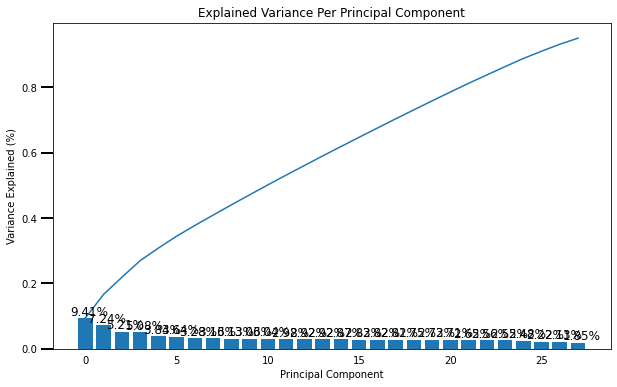

In [174]:
def pca_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
pca_plot(pca)

In [175]:
#Create sparse matrices to run the scikit multilearn algorithms

X_train_pca = lil_matrix(X_train_pca).toarray()
y_train = lil_matrix(y_train).toarray()
X_test_pca = lil_matrix(X_test_pca).toarray()
y_test = lil_matrix(y_test).toarray()

In [176]:
# using binary relevance
# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

BR_classifier = BinaryRelevance(GaussianNB())
# train
BR_classifier.fit(X_train, y_train)
# predict
predictions = BR_classifier.predict(X_test)
# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))


Accuracy =  0.5732103194942765
--- Run time: 0.0 mins ---


In [177]:
# initialize classifier chains multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

CC_classifier = ClassifierChain(GaussianNB())

# train
CC_classifier.fit(X_train, y_train)

# predict
predictions = CC_classifier.predict(X_test)

accuracy_score(y_test,predictions)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictions)))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Test accuracy is 0.8441824705279344
--- Run time: 0.0 mins ---


In [178]:
# initialize Label Powerset multi-label classifier
# with a gaussian naive bayes base classifier
start_time = time.time()

LP_classifier = LabelPowerset(GaussianNB())

# train
LP_classifier.fit(X_train, y_train)

# predict
predictions = LP_classifier.predict(X_test)

accuracy_score(y_test,predictions)
print('Test accuracy is {}'.format(accuracy_score(y_test, predictions)))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

Test accuracy is 0.7295404066290792
--- Run time: 0.01 mins ---


In [180]:
start_time = time.time()

MLKNN_classifier = MLkNN(k=1)

# train
MLKNN_classifier.fit(X_train_pca, y_train)

# predict mlknn = 1
predictions = MLKNN_classifier.predict(X_test_pca)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))

print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass n_neighbors=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy =  0.9998291474457544
--- Run time: 0.13 mins ---


In [ ]:
#This is takes a long time to run
#Find the optimal set of parameters

start_time = time.time()

parameters = {'k': range(1,100), 's': [0.5, 0.7, 1.0]}

score = 'accuracy'


clf = GridSearchCV(MLkNN(), parameters, scoring=score, cv=5)
clf.fit(X_train_pca, y_train)

print (clf.best_params_, clf.best_score_)
print("--- Run time: %s mins ---" % np.round(((time.time() - start_time)/60),2))

In [81]:
#See the predictions and translate them

#map the labels to their name
labels = y.columns.tolist() 
lables_dict = {key: i for i, key in enumerate(labels)}

#Turn predictions into readable list of lists
my_predictions = predictions.rows.tolist()

#translate the values to their keys.
#Change the my_predictions[0] value to
#my_predictions[index_value] to translate insights
for i in range(len(y_test)):
    get_keys = [k for k, v in lables_dict.items() 
                if v in my_predictions[i]]

    print(f'{i+1}',get_keys)

1 ['roomid_214']
2 ['roomid_213']
3 ['roomid_213']
4 ['roomid_214']
5 ['roomid_214']
6 ['roomid_213']
7 ['roomid_111']
8 ['roomid_111']
9 ['roomid_111']
10 ['roomid_111']
11 ['roomid_213']
12 ['roomid_111']
13 ['roomid_214']
14 ['roomid_111']
15 ['roomid_111']
16 ['roomid_111']
17 ['roomid_214']
18 ['roomid_213']
19 ['roomid_214']
20 ['roomid_111']
21 ['roomid_111']
22 ['roomid_111']
23 ['roomid_214']
24 ['roomid_111']
25 ['roomid_111']
26 ['roomid_213']
27 ['roomid_111']
28 ['roomid_111']
29 ['roomid_213']
30 ['roomid_214']
31 ['roomid_111']
32 ['roomid_214']
33 ['roomid_213']
34 ['roomid_111']
35 ['roomid_111']
36 ['roomid_214']
37 ['roomid_111']
38 ['roomid_214']
39 ['roomid_111']
40 ['roomid_111']
41 ['roomid_111']
42 ['roomid_111']
43 ['roomid_213']
44 ['roomid_213']
45 ['roomid_111']
46 ['roomid_111']
47 ['roomid_213']
48 ['roomid_111']
49 ['roomid_214']
50 ['roomid_213']
51 ['roomid_213']
52 ['roomid_214']
53 ['roomid_213']
54 ['roomid_213']
55 ['roomid_214']
56 ['roomid_214']
5

629 ['roomid_214']
630 ['roomid_213']
631 ['roomid_111']
632 ['roomid_111']
633 ['roomid_111']
634 ['roomid_111']
635 ['roomid_111']
636 ['roomid_111']
637 ['roomid_214']
638 ['roomid_213']
639 ['roomid_213']
640 ['roomid_111']
641 ['roomid_111']
642 ['roomid_111']
643 ['roomid_111']
644 ['roomid_111']
645 ['roomid_111']
646 ['roomid_111']
647 ['roomid_111']
648 ['roomid_214']
649 ['roomid_213']
650 ['roomid_213']
651 ['roomid_213']
652 ['roomid_111']
653 ['roomid_213']
654 ['roomid_213']
655 ['roomid_111']
656 ['roomid_213']
657 ['roomid_111']
658 ['roomid_111']
659 ['roomid_111']
660 ['roomid_213']
661 ['roomid_111']
662 ['roomid_111']
663 ['roomid_111']
664 ['roomid_111']
665 ['roomid_111']
666 ['roomid_111']
667 ['roomid_214']
668 ['roomid_213']
669 ['roomid_111']
670 ['roomid_111']
671 ['roomid_213']
672 ['roomid_213']
673 ['roomid_111']
674 ['roomid_213']
675 ['roomid_111']
676 ['roomid_111']
677 ['roomid_111']
678 ['roomid_111']
679 ['roomid_214']
680 ['roomid_213']
681 ['roomid

1129 ['roomid_214']
1130 ['roomid_213']
1131 ['roomid_213']
1132 ['roomid_214']
1133 ['roomid_214']
1134 ['roomid_111']
1135 ['roomid_111']
1136 ['roomid_111']
1137 ['roomid_111']
1138 ['roomid_214']
1139 ['roomid_214']
1140 ['roomid_111']
1141 ['roomid_111']
1142 ['roomid_213']
1143 ['roomid_214']
1144 ['roomid_213']
1145 ['roomid_213']
1146 ['roomid_213']
1147 ['roomid_214']
1148 ['roomid_111']
1149 ['roomid_111']
1150 ['roomid_111']
1151 ['roomid_111']
1152 ['roomid_111']
1153 ['roomid_213']
1154 ['roomid_111']
1155 ['roomid_214']
1156 ['roomid_214']
1157 ['roomid_213']
1158 ['roomid_111']
1159 ['roomid_111']
1160 ['roomid_111']
1161 ['roomid_111']
1162 ['roomid_214']
1163 ['roomid_111']
1164 ['roomid_111']
1165 ['roomid_111']
1166 ['roomid_111']
1167 ['roomid_214']
1168 ['roomid_213']
1169 ['roomid_214']
1170 ['roomid_111']
1171 ['roomid_111']
1172 ['roomid_111']
1173 ['roomid_111']
1174 ['roomid_111']
1175 ['roomid_111']
1176 ['roomid_111']
1177 ['roomid_213']
1178 ['roomid_111']


In [82]:
# Load the validationData
validationData = r'C:\Users\Thesis2.0\django_thesis\KNN Algorithm\validationData.csv'
validationData = pd.read_csv(validationData)

In [83]:
#Prepare Data for Model

#Clean data
validationData  = clean_data(validationData)

#preprocess
X_valid, y_valid = preprocess_data(validationData)

#scale
X_valid = scaler.transform(X_valid)

#pca
X_valid_pca = pca.transform(X_valid)

print("Number of PCA Components = {}.".format(pca.n_components_))

print("Total Variance Explained by PCA Components = {}.".format(pca.explained_variance_ratio_.sum()))

#Convert to sparse matrix
X_valid_pca = lil_matrix(X_valid_pca).toarray()
y_valid = lil_matrix(y_valid).toarray()

KeyError: "['roomid'] not found in axis"

In [84]:
from joblib import dump, load
dump(MLKNN_1_classifier, 'MLKNN_1_classifier.joblib')

NameError: name 'MLKNN_1_classifier' is not defined

In [85]:
#load pickled model
MLKNN_1_classifier = load('MLKNN_1_classifier.joblib') 

In [ ]:
# predict mlknn =1
valid_predictions = MLKNN_1_classifier.predict(X_valid_pca)

# accuracy
print("Accuracy = ",accuracy_score(y_valid,valid_predictions))